# Shape Bias

In [26]:
!pip install timm transformers

Imports


In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision import models
from tqdm import tqdm
import timm
from transformers import CLIPProcessor, CLIPModel

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as TF  # To convert tensor to PIL image
from PIL import Image, ImageOps
import cv2
import os

from torchvision import datasets
from torchvision.transforms import ToTensor

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Device Agnostic


In [28]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load Dataset

In [29]:
# Transform for both original and edge datasets (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale images to RGB
    transforms.ToTensor()
])

In [30]:
# Load the dataset
train_dataset = torchvision.datasets.Caltech101(
    root='./data',
    download=True,
    transform=transform,
    target_type="category"
)

# Splitting the dataset into training and validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
classes = train_dataset.dataset.categories  # List of categories


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Files already downloaded and verified


In [31]:
print(classes)
print(len(classes))

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

Canny Edge Detection Transformation

In [32]:
# Step 1: Define the Canny edge detection transform
def edge_transform(image):
      # Convert tensor to PIL Image if necessary
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    grayscale_image = ImageOps.grayscale(image)

    # Convert to numpy array
    np_img = np.array(grayscale_image)

    # Apply Canny edge detection
    edges = cv2.Canny(np_img, threshold1=100, threshold2=200)

    # Convert back to PIL Image and convert to RGB
    edge_image = Image.fromarray(edges).convert("RGB")

    # Convert the edge image back to a tensor
    return TF.to_tensor(edge_image)

Generating Dataset of Edges

In [33]:
class CaltechEdgeDataset(Dataset):
    def __init__(self, dataset, transform=None, edge_transform_func=None):
        self.dataset = dataset  # Use the already split dataset (validation set)
        self.transform = transform
        self.edge_transform_func = edge_transform_func

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the original image and its label
        image, label = self.dataset[idx]
        # print("Label:", label)
        # print(len(classes))
        class_label = classes[label]

        # print("class_label:", class_label, "Classes[label]:", classes[label])

        # Apply the normal transform to the original image
        if self.transform:
            image = self.transform(image)

        # Apply edge transform if function is provided
        if self.edge_transform_func:
            edge_image = self.edge_transform_func(image)  # Already in tensor form
        else:
            edge_image = image

        return image, edge_image, label, class_label


In [34]:
root_dir = "/content/data/caltech101/101_ObjectCategories"  # Path to Caltech101 dataset

# Transform for both original and edge datasets (resize and convert to tensor)
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale images to RGB
    # transforms.ToTensor()
])

# Apply the edge transformation only to the validation set
caltech_edge_val_dataset = CaltechEdgeDataset(dataset=val_dataset, transform=transform, edge_transform_func=edge_transform)


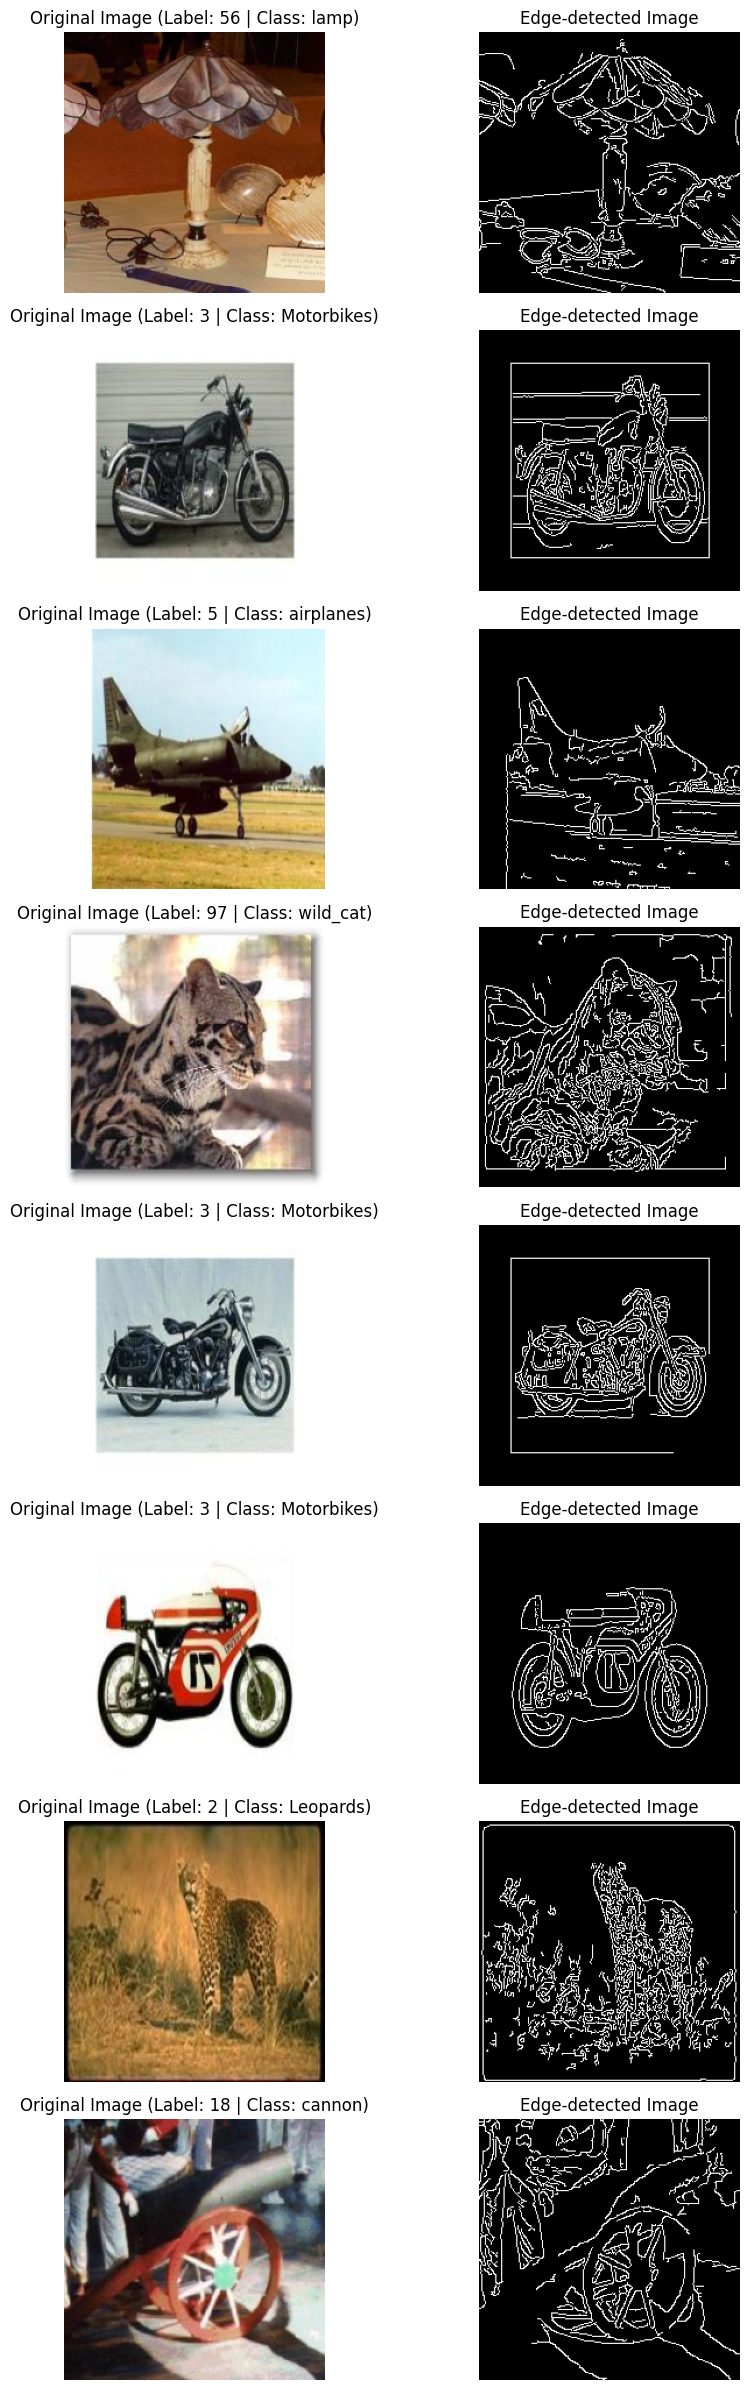

In [35]:

# Create a DataLoader for the validation edge dataset
val_edge_loader = DataLoader(caltech_edge_val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Step 5: Plot a few randomly chosen images with edges along with the originals
def plot_random_images_with_edges(dataloader):
    # Get a batch of images
    images, edge_images, labels, batch_classes = next(iter(dataloader))

    # Plot original images and edge-transformed images side by side
    fig, axs = plt.subplots(8, 2, figsize=(10, 24))

    for i in range(8):
        # Original image
        axs[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert Tensor to (H, W, C) for display
        axs[i, 0].set_title(f"Original Image (Label: {labels[i]} | Class: {batch_classes[i]})")
        axs[i, 0].axis("off")

        # Edge-detected image
        axs[i, 1].imshow(edge_images[i].permute(1, 2, 0))  # Convert Tensor to (H, W, C) for display
        axs[i, 1].set_title("Edge-detected Image")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Step 6: Call the plot function to display images
plot_random_images_with_edges(val_edge_loader)

# ResNet101

## Finetuning On Baseline Train Dataset

Importing Pretrained Model

In [36]:
resnet_model = models.resnet101(pretrained=True)

# Freeze all layers except the classification head
for param in resnet_model.parameters():
    param.requires_grad = False

# Step 4: Modify the final layer for Caltech101 (102 classes: 101 + 1 background)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 101)

# Move the model to the GPU if available
resnet_model = resnet_model.to(device)

# Step 5: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)


Finetuning the model

In [37]:
num_epochs = 3
resnet_train_acc = 0

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap the train_loader with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    resnet_train_acc = 100 * correct / total


Training Epoch 1/3: 100%|██████████| 190/190 [00:51<00:00,  3.71batch/s]


Epoch 1/3, Loss: 1.3502, Accuracy: 73.80%


Training Epoch 2/3: 100%|██████████| 190/190 [00:44<00:00,  4.26batch/s]


Epoch 2/3, Loss: 0.2825, Accuracy: 94.04%


Training Epoch 3/3: 100%|██████████| 190/190 [00:48<00:00,  3.93batch/s]

Epoch 3/3, Loss: 0.1700, Accuracy: 96.38%


## Evaluation

Validation on Baseline Dataset's Val Split

In [38]:
resnet_baseline_val_acc = 0

resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_loader with tqdm
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
resnet_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [00:18<00:00,  4.45batch/s]

Validation Accuracy: 92.09%


Validation on Modified Dataset

In [39]:
# Initializing variables for heatmap data
all_labels = []
all_predictions = []

resnet_edge_val_acc = 0

val_edge_loader = DataLoader(caltech_edge_val_dataset, batch_size=32, shuffle=False, num_workers=0)

resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_edge_loader with tqdm
    for images, edge_images, labels, batch_classes in tqdm(val_edge_loader, desc="Validating", unit="batch"):
        edge_images, labels = edge_images.to(device), labels.to(device)

        outputs = resnet_model(edge_images)
        _, predicted = torch.max(outputs, 1)

        # Accumulate labels and predictions for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print validation accuracy
resnet_edge_val_acc = 100 * correct / total
print(f"Validation Accuracy: {resnet_edge_val_acc:.2f}%")

Validating: 100%|██████████| 82/82 [00:26<00:00,  3.15batch/s]

Validation Accuracy: 9.56%


Shape Bias for ResNet101


In [40]:
resnet_shape_bias = resnet_edge_val_acc / resnet_baseline_val_acc
print(f"Shape Bias = {resnet_shape_bias:.4f}")

Shape Bias = 0.1038


# Vision Transformer

## Finetuning On Baseline Train Dataset

Importing Pretrained Model

In [41]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze the feature extractor backbone
for param in vit_model.parameters():
    param.requires_grad = False

# Replace the classifier head with a new head for 101 classes
vit_model.head = nn.Linear(vit_model.head.in_features, 101)
vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

Finetuning the model

In [42]:
num_epochs = 3
vit_train_acc = 0

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap the train_loader with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    vit_train_acc = 100 * correct / total


Training Epoch 1/3: 100%|██████████| 190/190 [01:15<00:00,  2.50batch/s]


Epoch 1/3, Loss: 2.8094, Accuracy: 54.19%


Training Epoch 2/3: 100%|██████████| 190/190 [01:16<00:00,  2.49batch/s]


Epoch 2/3, Loss: 0.9533, Accuracy: 89.68%


Training Epoch 3/3: 100%|██████████| 190/190 [01:16<00:00,  2.47batch/s]

Epoch 3/3, Loss: 0.4350, Accuracy: 94.35%


## Evaluation

Validation on Baseline Dataset's Val Split

In [43]:
vit_baseline_val_acc = 0

vit_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_loader with tqdm
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vit_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
vit_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [00:34<00:00,  2.40batch/s]

Validation Accuracy: 94.32%


Validation on Modified Dataset

In [44]:
# Initializing variables for heatmap data
all_labels = []
all_predictions = []

vit_edge_val_acc = 0

val_edge_loader = DataLoader(caltech_edge_val_dataset, batch_size=32, shuffle=False, num_workers=0)

vit_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_edge_loader with tqdm
    for images, edge_images, labels, batch_classes in tqdm(val_edge_loader, desc="Validating", unit="batch"):
        edge_images, labels = edge_images.to(device), labels.to(device)

        outputs = vit_model(edge_images)
        _, predicted = torch.max(outputs, 1)

        # Accumulate labels and predictions for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print validation accuracy
vit_edge_val_acc = 100 * correct / total
print(f"Validation Accuracy: {vit_edge_val_acc:.2f}%")

Validating: 100%|██████████| 82/82 [00:39<00:00,  2.06batch/s]

Validation Accuracy: 51.69%


Shape Bias for ViT


In [45]:
vit_shape_bias = vit_edge_val_acc / vit_baseline_val_acc
print(f"Shape Bias = {vit_shape_bias:.4f}")

Shape Bias = 0.5480


# CLIP ViT

Importing Pretrained Model

In [46]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

clip_model.to(device)

# Prepare text inputs (class prompts) for zero-shot classification
text_inputs = [f"a photo of a {class_label}" for class_label in classes]
text_inputs = processor(text=text_inputs, return_tensors="pt", padding=True).to(device)

## Evaluation

Validation on Baseline Dataset's Val Split

In [47]:
clip_baseline_val_acc = 0

clip_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_loader with tqdm
    for inputs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        # inputs, labels = inputs.to(device), labels.to(device)

        # Preprocess images and move to the device
        images = [transforms.ToPILImage()(image) for image in inputs]  # Convert tensors back to PIL
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        # Encode the image and text inputs
        image_features = clip_model.get_image_features(**inputs)
        text_features = clip_model.get_text_features(**text_inputs)

        # Normalize the embeddings
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity between image and text
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get the predicted class (highest similarity)
        predicted_classes = similarity.argmax(dim=-1)

        # Update correct predictions
        correct += (predicted_classes == labels.to(device)).sum().item()
        total += labels.size(0)


print(f"Validation Accuracy: {100 * correct / total:.2f}%")
clip_baseline_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [02:16<00:00,  1.66s/batch]

Validation Accuracy: 88.21%


Validation on Modified Dataset

In [48]:
clip_edge_val_acc = 0

clip_model.eval()
correct = 0
total = 0
with torch.no_grad():
    # Wrap the val_loader with tqdm
    for images, edge_images, labels, batch_classes in tqdm(val_edge_loader, desc="Validating", unit="batch"):
        # inputs, labels = inputs.to(device), labels.to(device)

        # Preprocess images and move to the device
        images = [transforms.ToPILImage()(image) for image in edge_images]  # Convert tensors back to PIL
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        # Encode the image and text inputs
        image_features = clip_model.get_image_features(**inputs)
        text_features = clip_model.get_text_features(**text_inputs)

        # Normalize the embeddings
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity between image and text
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get the predicted class (highest similarity)
        predicted_classes = similarity.argmax(dim=-1)

        # Update correct predictions
        correct += (predicted_classes == labels.to(device)).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")
clip_edge_val_acc = 100 * correct / total

Validating: 100%|██████████| 82/82 [02:22<00:00,  1.74s/batch]

Validation Accuracy: 66.17%


Shape Bias for CLIP

In [49]:
clip_shape_bias = clip_edge_val_acc / clip_baseline_val_acc
print(f"Shape Bias = {clip_shape_bias:.4f}")

Shape Bias = 0.7501


# Shape Biases

In [50]:
from tabulate import tabulate

# Assuming these are your calculated shape biases
shape_biases = {
    "Model 1: ResNet101": resnet_shape_bias,
    "Model 2: ViT": vit_shape_bias,
    "Model 3: Clip-ViT-Large": clip_shape_bias,
}

# Creating a list of lists for table format
table_data = [[model, f"{bias:.4f}"] for model, bias in shape_biases.items()]

# Define the table headers
headers = ["Model", "Shape Bias"]

# Print the table in a fancy format
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒═════════════════════════╤══════════════╕
│ Model                   │   Shape Bias │
╞═════════════════════════╪══════════════╡
│ Model 1: ResNet101      │       0.1038 │
├─────────────────────────┼──────────────┤
│ Model 2: ViT            │       0.548  │
├─────────────────────────┼──────────────┤
│ Model 3: Clip-ViT-Large │       0.7501 │
╘═════════════════════════╧══════════════╛
